In [1]:
addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [1]:
@everywhere begin
#using Plots
using DWave
#using Interact
end


Use "Dict(a=>b, ...)" instead.

Use "Dict(a=>b, ...)" instead.


In [2]:
gadfly()

LoadError: LoadError: UndefVarError: gadfly not defined
while loading In[2], in expression starting on line 1

# Benchmarking performance of stochastic optimization algorithms using binary criteria

## Intro
The development of the D-Wave line of quantum annealers has sparked a flurry of activity in the optimization and quantum computation community, and spurred a small cottage industry around benchmarking their performance. This work is not concerned with the results of such analyses, but with the method of analysis itself. Our goal is rather to lay out guidelines which will hopefully aid all future researchers in this field perform the work of benchmarking future generations of D-Wave's devices, as well as competing optimization algorithms, in a consistent and standard way.

### The context
Suppose that you have some ensemble of problems whose properties depend on some set of parameters which you control, call them $λ$. Assume there is some mapping (or set of mappings) which takes in a problem $H(λ)$ and which outputs a new Hamiltonian which depends on $λ$ and a set of nuisance variables $θ$. Each solver takes in some problem $H(λ,θ)$ (i.e. $H(λ)$ modified by nuisance parameters $θ$) and outputs a trial solution $\vec{s}$ under some set of solver parameters χ. We have some mechanism which maps a solution $\vec{s}$ into a binary output $s=0,1$ for "failure" and "success" respectiely.

We seek to estimate $p_s = \langle Pr(s=1|H(λ),χ) \rangle_θ$, for a given solver. Here we average over θ as these nuisance parameters, as the name suggests, are not under our control.

Here, λ would be the list of all couplers in the Hamiltonian, but it could also include things like the range of ranodm Ising problems, the loop density in the frustrated loops planted solutions, chain strength in an embedded problem, etc. Any property of an instance which, contextually, we wish to account for and track explicitly. The θ would be something like the physical couplers of the programmed Hamiltonian, which are inaccessible and sotchastic. Certain properties may lie on either side of this boundary depending on context. If one is studying the correlation between particular embeddings of full connected problems into Chimera, then embeddings would be in λ. If one instead simply views different embeddings as different, randomly selected, representations of the same underlying problem, then embedding would be in θ. Of course, things like annealing time, number of sweeps, initial and final temperature, number of replicas, etc. (depending on your algorithm) constitute χ.

### Ideal mechanism
If one resamples from θ for every solution in H(λ) according to it's intrinsic distribution, then the expected probability of success at any trial is exactly $p_s$. By resampling, we effectively render the success or failure of each new solution a simple Bernoulli trial. We are then seeking to simply estimate the probability of success of some Bernoulli trial. To do so, one uses a conjugate prior to the Benoulli distribution, namely the Beta distribution. Conjugate priors have the helpful property that if you use one and then perform additional trials and update on the evidence, your posterior distribution will be of the same family as your prior. For the Beta distribution with a prior Beta(c_1,c_2) and a sequence of N trials with x successes, the posterior is simply Beta(x+c_1,N-x+c_2). c_1 can thus be considered the prior's number of successes and c_2 the prior's number of failures.

The choice of prior has negligible impact to the posterior distribution when c_1 << x and c_2 << N-x. Generally, c_1=c_2=c, and there are three common choices -- $c = 0$, $\frac12$, or $1$. $c=1$ is the uniform distribution on [0,1]. $c=\frac12$ is the arcsine distribution, and is the Jeffrey's prior for the Beta distribution, namely the prior which is the square root of the determinant of the Fisher information (which is invariant under various reparameterization). Finally, $c=0$ is the Haldane prior, which is a half-delta function at 0 and another at 1. The Haldane distribution is the only one for whom the mean of the posterior is equal to the $x/N$, in general it is equal to $\frac{x+c_1}{N+c_1+c_2}$ for a Beta(c_1,c_2) prior. The standard deviation is $\big(\frac{(x+c_1)(N-x+c_2)}{(N+c_1+c_2)^2(N+c_1+c_2)}\big)^\frac12$. The coefficient of variation, $\sigma/\mu=\sqrt{\frac{N-x+c_2}{(x+c_1)(N+c_1+c_2)}}$. If c_1 and c_2 are small relative to $N-x$ and $N$, this is approximately $\frac1x-\frac1N$, and for large $N$ it is really just $\frac1x$.

We immediately see an important lesson: the coefficient of variation of $p_s$ is controlled by the number of successes that we see. Thus, if we wish to estimate to within a fixed variation, we require the number of successes to be approximately constant.

# Benchmarking performance of stochastic optimization algorithms using binary criteria

### Joshua Job

### The Problem:

Given a map $\Phi(\lambda,\theta): \{0,1\}^n \rightarrow 0,1$ estimate $\langle \Phi \rangle_\theta = \mu(\lambda) \in (0,1)$. $\Phi$ classifies a solution as either a success or failure, $\theta$ form nuisance parameters and $\lambda$ are our parameters of interest. $\theta$ may contain variables outside our control, and whose distribution we may not know.



Interact.Slider{Float64}([Reactive.Input{Float64}] 0.5,"p",0.5,0.001:0.001:1.0)

Interact.Slider{Int64}([Reactive.Input{Int64}] 5000,"N",5000,0:10000)

Interact.Options{:ToggleButtons,Float64}([Reactive.Input{Float64}] 0.0,"c",0.0,"0.0",Interact.OptionDict(Any["0.0","0.5","1.0"],Dict{Any,Any}("0.5"=>0.5,"0.0"=>0.0,"1.0"=>1.0)),Any[],Any[])

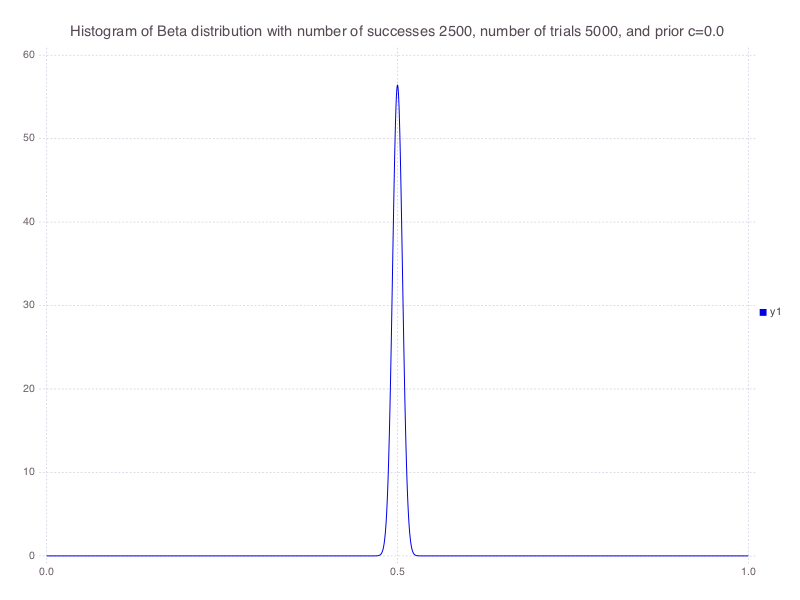

In [188]:
#hideme
@manipulate for p=1e-3:1e-3:1,N=0:10000,c=[0,1/2,1]
    plot(0:1e-4:1,pdf(Beta(p*N+c,N*(1-p)+c),0:1e-4:1))
    title!("Histogram of Beta distribution with number of successes "*string(round(Integer,p*N))*", number of trials "
    *string(N)*", and prior c="string(c))
end

# Practicalities

### Practicalities
While a method of operation like this is available to us for some algorithms (those on classical hardware for the most part), to resample θ at each solution on D-Wave hardware is untenable due to the long programming time. If run in such a mode, the D-Wave chip will be annealing only $1\%$ of the time. Thus, out of practical necessity we must sample multiple states from each value of θ and then take an average to estimate $p_s$.

For each set of trials (equivalent to a programming cycle on the D-Wave processor) we can use a Beta distribution to encode our knowledge about the probablity of success for that set, and then compute our belief about the average value over all sets. Now, the choice of prior is not irrelevant. Since we know we cannot run an unlimited number of anneals with a single programming cycle, and thus a single sample from θ, we will inevitably reach a point where the overwhelming majority of our programming cycles have zero successes. If our prior on p_success for a gauge has any bias in the average value, then we'll have a bias of the same magnitude in our estimate for the average, $p_s$. Thus, for very difficult problems, with low success probabilities, our prior will swamp our data and we will learn nothing no matter how many anneals we perform. Thus, we are forced to choose the Haldane prior, Beta(0,0), as it is the only Beta distribution prior whose mean is equal to the empirical success rate and thus is not biased by prior information.

One may notice that taking an average over a single set of samples from θ completely destroys any ignorance we have coming out of uncertainty about the distribution θ. A common way to address such ignorance is via the classical bootstrap.

#### The classical bootstrap
In a classical bootstrap, one makes the following assumptions:
1. All values that may be sampled from the distribution have been. (One has seen every type in the population.)
2. All frequencies of the types in the population are exactly those in the empirical sample.

and then asks to estimate the sampling distribution for any given parameter of interest in your experimental setup by creating new pseudodata vectors by randomly generating new data vectors equal in length to those in one's experiment by sampling with the population specified these assumptions, namely by resampling the data vector.

The key is that the classical bootstrap mimics the *sampling* distribution. Take, for instance, the case where one has 10 gauges, 9 of whom have 0 successes and 1 of whom is all successes, after N trials in each gauge. Beta(0,N) for all values of N is simply a delta function at 0, so we can replace it with the value 0, and Beta(N,0) with 1. Say we want to estimate the mean probability of success. We would simply choose a number 1:10 uniformly at random, sample a value from the distribution of the corresponding gauge, and repeat 10 times, taking the average of the resulting numbers.

## The classical bootstrap
In a classical bootstrap, one makes the following assumptions:
1. All values that may be sampled from the distribution have been. (One has seen every type in the population.)
2. All frequencies of the types in the population are exactly those in the empirical sample.

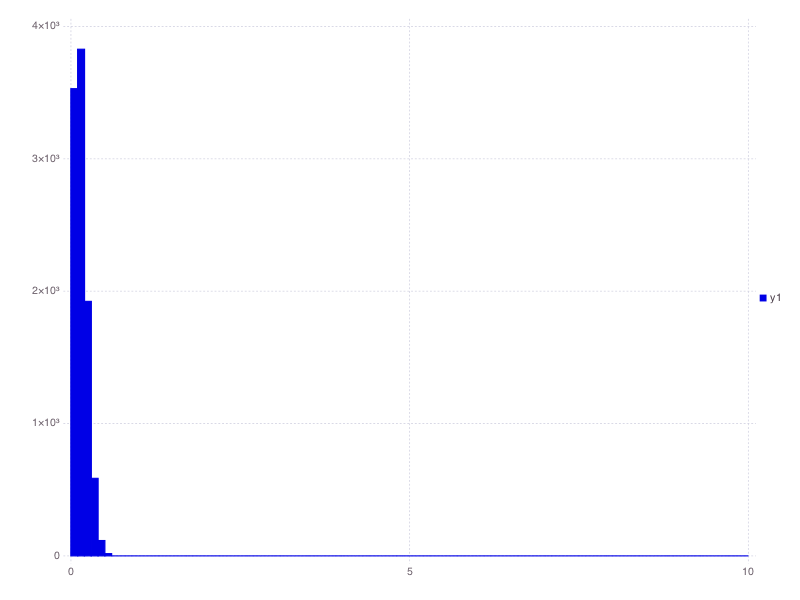

In [5]:
val=0.
vals=zeros(10^4)
data = [0,0,0,0,0,0,0,0,0,1] 
# since we are using Haldane's prior and every gauge was either all success or all failure
# we can replace all our Beta distributions with 0 or 1, for convenience
p_s = [mean(sample(data,length(data)))::Float64 for i=1:10^4] 
# sample from data a new vector of length data and compute the mean
histogram(p_s)
xlims!((0,1))

As you can see, you have nonnegligible $p_s=0$. But of course, this isn't $p_s$, this is our bootstrapped estimate of the sampling distribution for our statistic. The practitioner of the classical bootstrap then is left with few options when attempting to move to sampling from the distribution for time to solution, which goes like $1/p_s$, since it will have significant support on TTS$=\infty$ when this is clearly not a reasonable conclusion given the data. This gets to a deeper issue: if the bootstrap is supposed to somehow represent my knowledge or information about $p_s$, then it clearly fails. I have seen successes, yet this places nonzero weight on the belief that the average probability of success is 0. We aren't interested in the *sampling distribution* of our parameter of interest; we're interested in a *posterior distribution*, which is quite different conceptually and, as one can see, in practice.

To drive home this point, consider also the case where we have 100 gauges, each with 2000 anneals, and a distribution of probability of success chosen from a mixture of Normal(0.05,0.003) with weight 0.95 and Normal(0.4,0.01) with weight 0.05, and observe what the classical bootstrap has to say about the mean probability of success in this case as well:

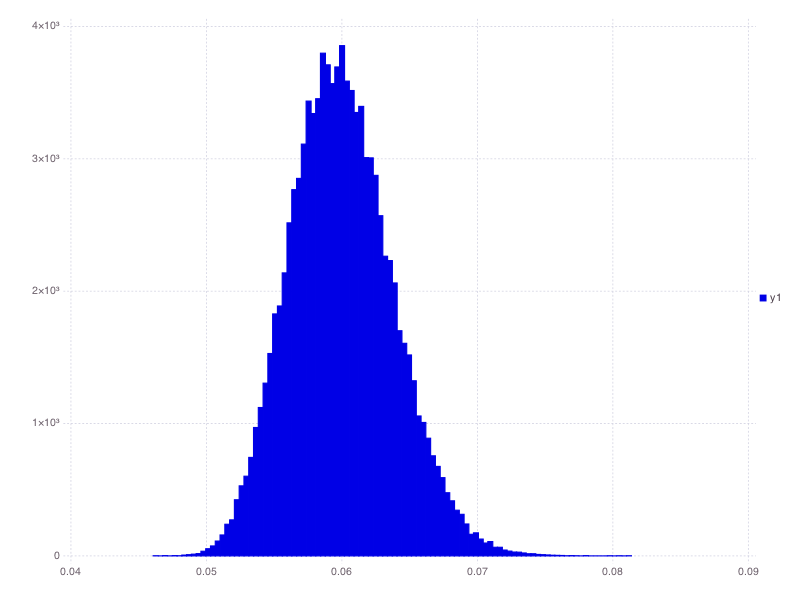

In [6]:
mm = MixtureModel([Normal(0.05,0.003),Normal(0.4,0.01)],[0.95,0.05])
probabilities = rand(mm,200) # probability of success of each gauge
number_of_successes = [rand(Binomial(1000,p))::Int64 for p in probabilities] # number of success in each gauge

function randhaldanebeta(x,n)
    out=0.
    if x==0
        out = 1.
    elseif x==1
        out = 0.
    else
        out = rand(Beta(x,n))
    end
    return out
end
# since we are using Haldane's prior and every gauge was either all success or all failure
# we can replace all our Beta distributions with 0 or 1, for convenience
p_s = [mean(map(x->randhaldanebeta(2x,2000),
    sample(number_of_successes,length(number_of_successes))))::Float64 for i=1:10^5] 
# sample from data a new vector of length data and compute the mean
histogram(p_s)
#xlims!((0,1))

As you can see, the sampling distribution has a number of peaks which one would not expect from a posterior distribution about a mean. These arise due to the discrete nature of the classical bootstrap --- in each sample, there is a certain discrete number of the large-mean distributions that were sampled. They overwhelm the variation over the other gauges, effectively creating a Binomial distribution on the number of gauges with high probability sampled (rescaled by their mean probability) with Gaussian noise centered on each discrete value. 

While this problem can be "fixed" by simply collecting more data, the fundamental problem will remain --- frequentist statistics estimate uncertainty due to sampling, not our uncertainy about parameters. To do that will require a Bayesian approach to modeling uncertainty.

#### The Bayesian bootstrap
Bayesian nonparametric estimation can be difficult to use and is often sensitive to the choice of prior. Traditionally, Bayesian nonparametric estimation has used the Dirichlet Process prior with some kernel function (usually Gaussian). The posterior mean of this distribution is equal to a Dirichlet distribution over the observed values. Rubin (1981) proposed using this distribution as a Bayesian version of the classical bootstrap. It can be understood as based on two assumptions:

1. All values that may be sampled from the distribution have been. (One has seen every type in the population.)
2. The true population distribution is unknown. We merely have sampled G times and seen all G types (as per 1).

To encode (2) mathematically, we note that the conjugate prior to the categorical and multinomial distributions is the Dirichlet distribution (whose equivalent of the Haldane prior is $Dirichlet(0,0,0,0,0,...)$). Thus, we take the standard prior for the G-dimensional Dirichlet distribution and update based on having seen each type once, yielding the $Dirichlet(1,1,1,1,...,1)$ distribution. Rather than sampling a vector of finite length at each sample, one samples from the Dirichlet distribution to find the weights for each element in the population to get a bootstrap sample population on which to compute whatever statistic one desires.

The major benefit of the Bayesian bootstrap is that it yields continuous results for the mean for any continuous probability distribution. It also has a more reasonable assumption than the classical bootstrap --- rather than asserting certainty about the distribution in the population, it assumes that we are ignorant of this distribution and uses only the knowledge we have. Finally, rather than representing some sampling distribution for a statistic, we are computing a genuine posterior distribution for our information about the statistic.

Let's examine the cases where the classical bootstrap broke down again, to see the advantages of the Bayesian bootstrap. In the case of 10 gauges with 9 having no successes and one having only successes. Since the population really only has two subpopulations, we can regroup the elements in our Dirichlet distribution, so that it is a distribution only over "those elements that always evaluate to zero when sampled" and "those elements that always evaluate to one when sampled". If one combined elements $i$ and $j$ in $Dirichlet(\alpha_1,\alpha_2,...,\alpha_i,...,\alpha_j,...,\alpha_G)$, the resulting distribution will also be a Dirichlet distribution, only with $G-1$ elements, all terms remaining the same except that instead of $\alpha_i,\alpha_j$ one has a single term $\alpha_i+\alpha_j$. In this case, this will result in Dirichlet(1,9). This is actually equivalent to Beta(1,9), since the probability of failure is $1-p_s$, and is thus the Beta distribution with a Haldane prior. In the case where the number of anneals per gauge is 1, we recover exactly our ideal.

In the second case, we have:

## The Bayesian bootstrap

1. All values that may be sampled from the distribution have been. (One has seen every type in the population.)
2. The true population distribution is unknown. We merely have sampled G times and seen all G types (as per 1).
    
The conjugate prior on the multinomial distribution is a Dirichlet distribution, with "natural" priors Dirichlet(c) for 0, 1/2, and 1.

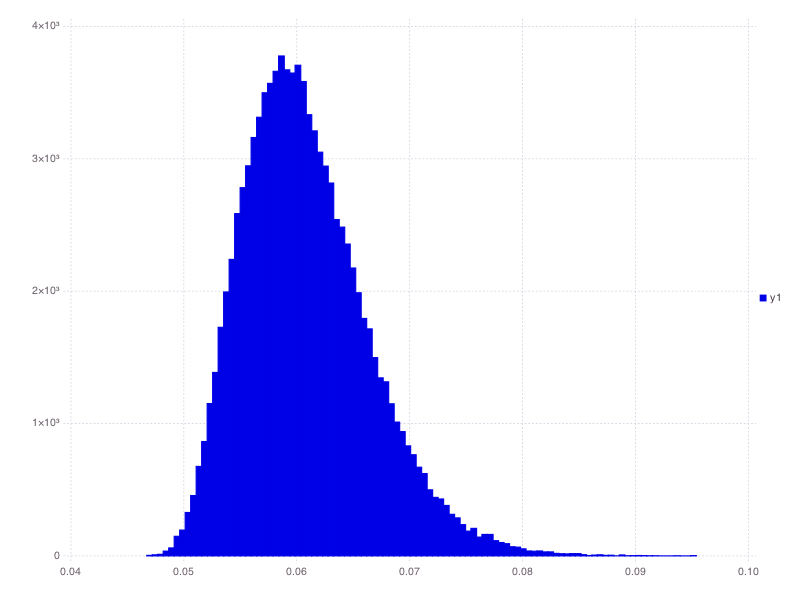

In [7]:
mm = MixtureModel([Normal(0.05,0.003),Normal(0.4,0.01)],[0.95,0.05])
probabilities = rand(mm,100) # probability of success of each gauge
number_of_successes = [rand(Binomial(1000,p))::Int64 for p in probabilities] # number of success in each gauge

function randhaldanebeta(x,n)
    out=0.
    if x==0
        out = 1.
    elseif x==1
        out = 0.
    else
        out = rand(Beta(x,n))
    end
    return out
end
# since we are using Haldane's prior and every gauge was either all success or all failure
# we can replace all our Beta distributions with 0 or 1, for convenience
p_s = [mean(map(x->randhaldanebeta(2x,2000),
    number_of_successes),weights(rand(Dirichlet(ones(100)))))::Float64 for i=1:10^5] 
# sample from data a new vector of length data and compute the mean
histogram(p_s)

As one can see, this is smooth and continuous due to the continuous nature of the Bayesian bootstrap, which is a consequence of it's being a true posterior distribution for $p_s$.

The Bayesian bootstrap can be nested, just like the classical bootstrap. For instance, one may desire to compute the posterior for the median over a class of instances, such as range-1 random Ising problems for $C_8$ chimera graphs. To do so, one would draw a sample from the Bayesian bootstrap distribution for your data, yielding a weight vector and a vector of probabilities corresponding to each programming cycle. One then computes the median over this population (which may be very different than the median over the vector of probabilities alone) to extract a single sample of the median, and repeat many times to construct a Monte Carlo estimate of the posterior.

In [10]:
df = readtable("/Volumes/Data/Josh/Ising/data/qa/range_1_0_fields.dat")
head(df,10)

,R,N,L,fields,inst,S,progcycle,ΔE,ΔEs,success_standard,numSuccess,numReads
1,1,503,8,false,0,100,1,0,0,Δ,59,5000
2,1,503,8,false,1,100,1,0,0,Δ,1113,5000
3,1,503,8,false,2,100,1,0,0,Δ,96,5000
4,1,503,8,false,3,100,1,0,0,Δ,2,5000
5,1,503,8,false,4,100,1,0,0,Δ,30,5000
6,1,503,8,false,5,100,1,0,0,Δ,8,5000
7,1,503,8,false,6,100,1,0,0,Δ,77,5000
8,1,503,8,false,7,100,1,0,0,Δ,86,5000
9,1,503,8,false,8,100,1,0,0,Δ,3,5000
10,1,503,8,false,9,100,1,0,0,Δ,96,5000


In [11]:
BetaBayesianBootstrap(d2a(df[1:10,:numSuccess]),d2a(df[1:10,:numReads]))

DWave.BayesianBootstrap(Distributions.Sampleable{Distributions.Univariate,S<:Distributions.ValueSupport}[Distributions.Beta(α=59.0, β=5000.0),Distributions.Beta(α=1113.0, β=5000.0),Distributions.Beta(α=96.0, β=5000.0),Distributions.Beta(α=2.0, β=5000.0),Distributions.Beta(α=30.0, β=5000.0),Distributions.Beta(α=8.0, β=5000.0),Distributions.Beta(α=77.0, β=5000.0),Distributions.Beta(α=86.0, β=5000.0),Distributions.Beta(α=3.0, β=5000.0),Distributions.Beta(α=96.0, β=5000.0)],Real[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],10)

In [181]:
thing=by(df[df[:ΔE].==0,:],[:R,:N,:L,:fields,:inst,:S,:ΔE,:ΔEs,:success_standard],
x->TTSDistribution(BetaBayesianBootstrap(d2a(x[:numSuccess]),d2a(x[:numReads]-x[:numSuccess])),0.99,20)
    );

LoadError: SYSTEM: show(lasterr) caused an error

In [166]:
histogram(rand(restrict(thing,Dict(:N=>503,:S=>20,:inst=>27))[:x1][1],10^5))

LoadError: LoadError: UndefVarError: thing not defined
while loading In[166], in expression starting on line 1

In [167]:
thing2=by(thing,[:R,:N,:L,:fields,:S,:ΔE,:ΔEs,:success_standard],x->BayesianBootstrap(x[:x1]));

LoadError: LoadError: UndefVarError: thing not defined
while loading In[167], in expression starting on line 1

In [168]:
@time vals=quantile(restrict(thing2,Dict(:N=>503,:S=>20))[:x1][1],[0.05:0.05:0.95],10^3);

LoadError: LoadError: UndefVarError: thing2 not defined
while loading In[168], in expression starting on line 155

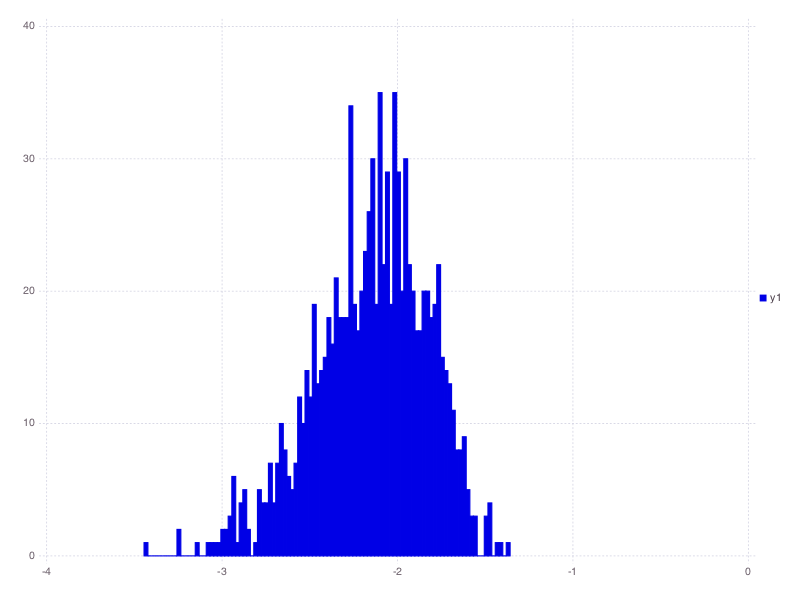

In [169]:
histogram(log10(vals[:,10]))

### Testing the data analysis procedure
Let us examine the procedure's veracity in the context of some artificial distributions with various properties.

First let's examine accuracy in estimating $p_s$ for a single instance. We'll test with a variety of distributions for the gauges: 
1. `Beta(1,9)`
2. `Beta(10,900)`
3. `Beta(50,1000)`
4. `Beta(10,10000)`
5. `MixtureModel([Beta(10,100),Beta(1,1000),Beta(900,1000)],[0.2,0.78,0.02])`
6. `10^Uniform(-10,-1)`
7. `10^Uniform(-4,-1)`
8. `MixtureModel([Beta(1,200),Beta(5,800),Beta(27,2303)])`

In [145]:
Beta(1,9), Beta(10,890), Beta(50,950), Beta(10,9990),
    MixtureModel([Beta(10,100),Beta(1,1000),Beta(900,1000)],[0.2,0.78,0.02]),
    10^Uniform(-4,-1), MixtureModel([Beta(1,200),Beta(5,800),Beta(27,2303)])

LoadError: SYSTEM: show(lasterr) caused an error

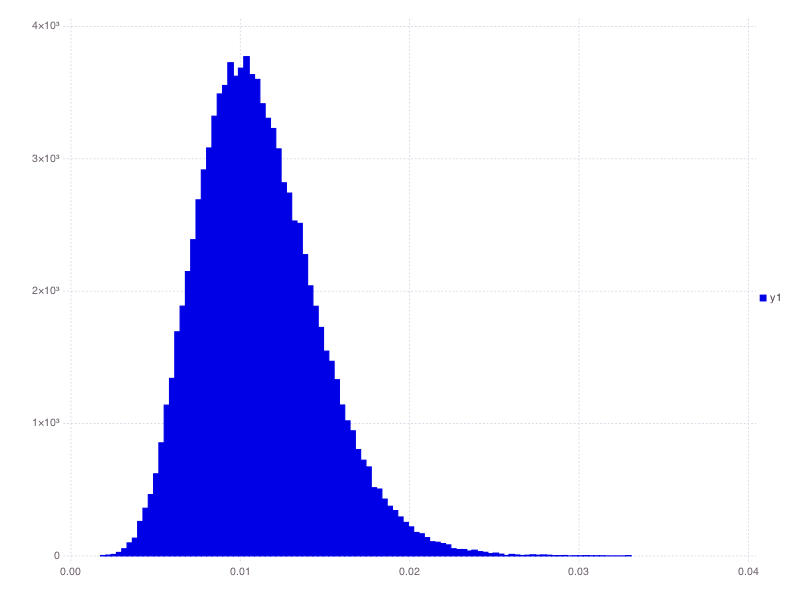

In [12]:
histogram(rand(Beta(10,890),10^5))

In [5]:
@everywhere mm=MixtureModel([Beta(1,100),Beta(1,1000),Beta(900,1000)],[0.2,0.68,0.12])
# probabilities = rand(mm,1000) # probability of success of each gauge
# number_of_successes = [rand(Binomial(1000,p))::Int64 for p in probabilities] # number of success in each gauge
# vals2=rand(BetaBayesianBootstrap(number_of_successes,1000*ones(1000)-number_of_successes,10^4));
# (mean(mm)-mean(vals))./std(vals)

In [30]:
mean(mm)

0.05950162396228055

In [31]:
function test_gauge_average(dist,R,N,n2=10^4)
    vals = zeros(n2,N)
    number_of_successes=Int64[] #zeros(G)
    ngnz=0
    for i=1:N
        #rdist=rand(dist,G)
        ngnz=0
        while (ngnz<100) || (ngnz < 2*R)
            push!(number_of_successes , StatsFuns.Rmath.binomrand(R, rand(dist)))
            (number_of_successes[end]>0) && (ngnz+=1)
            # direct sample from binomial with negligible allocation
        end
        vals[:,i]=rand(BetaBayesianBootstrap(number_of_successes,R.-number_of_successes),n2)
    end
    return vals
end

test_gauge_average (generic function with 2 methods)

In [39]:
@time vals=test_gauge_average(mm,100,1000,1);

 77.635122 seconds (1.10 G allocations: 33.661 GB, 17.93% gc time)


Interact.Slider{Int64}([Reactive.Input{Int64}] 500,"i",500,1:1000)

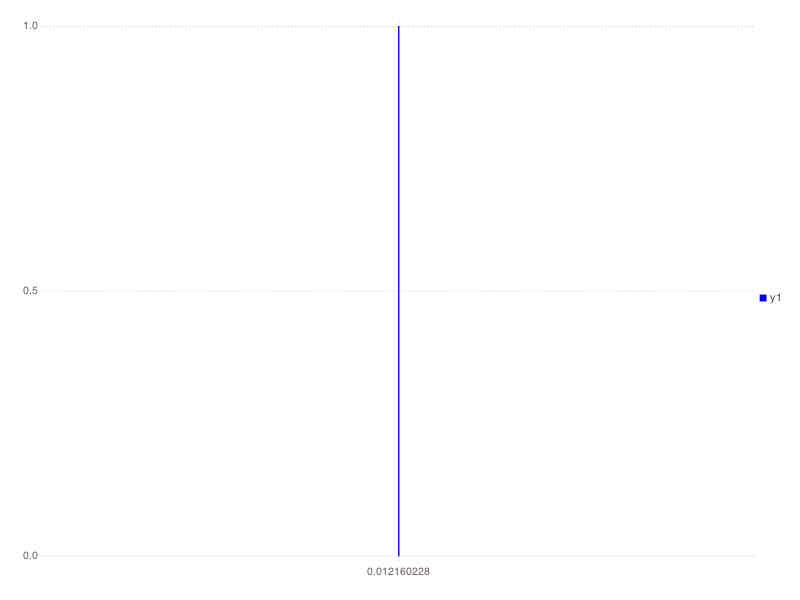

In [40]:
@manipulate for i=1:size(vals,2)
    histogram(vals[:,i])
end

In [250]:
@everywhere function data_collection_test(dist,R,n2,vl=0.001)
    number_of_successes=Float64[]
    nsuccess=0 ; ng=0 ; nt=0. ; t=0. ; ngnz = 0. ; v=1.
    while (nt<R) || (v>vl)
        t=StatsFuns.Rmath.binomrand(R, rand(dist))
        nt+=t
        push!(number_of_successes,t)
        ng+=1
        t>0 && (ngnz+=1)
        if mod(ng,100)==0
            x=rand(fastBBB(number_of_successes,R*ones(ng)-number_of_successes,0),n2)
            #println(maximum(x),' ',minimum(x),' ',mean(x),' ',var(x),' ',std(x))
            t=log(0.01)./log(1.-x)
            v = std(t)/mean(t)
            if v<vl
                x=rand(BetaBayesianBootstrap(number_of_successes,R*ones(ng)-number_of_successes,0),n2)
                t=log(0.01)./log(1.-x)
                v=std(t)/mean(t)
            end
            #println(v)
        end
    end
    vals=rand(BetaBayesianBootstrap(number_of_successes,R*ones(ng)-number_of_successes,0),max(1000,n2))
    ts = ng.*(15e-3+180e-6*R)
    return ng,ts,vals
end

_twait()=false
twait(x)=(timedwait(_twait,float(x));nothing);

function check_procedure(m,R,n2,v1,N)
    ngs = zeros(Int64,N)
    v=zeros(max(1000,n2),N)
    ts = zeros(max(1000,n2),N)
    vals = pmap(x->data_collection_test(x,R,n2,v1),[m::Distribution for i=1:N])
    for i=1:N
        ngs[i]=vals[i][1]
        v[:,i]=vals[i][3]
        ts[:,i]=vals[i][2]
    end
    return ngs,ts,v
end

function coverage_test(m,v)
    ng = v[1]; ts = v[2]; x = log(0.01)./log(1.-v[3])
    qs=zeros(size(x,2),6);
    out=zeros(Bool,size(x,2),3);
    out2=zeros(Bool,size(x,2),3);
    tm=log(0.01)/log(1-mean(m));
    μ=mean(x);σ=std(x)
    for i=1:size(x,2)
        qs[i,:]=quantile(x[:,i],0.5.+[-.9973/2,-.9545/2,-.6572/2,.6572/2,.9545/2,.9973/2])
        (tm>qs[i,1] && tm<qs[i,end]) && (out[i,3]=true)
        (tm>qs[i,2] && tm<qs[i,end-1]) && (out[i,2]=true)
        (tm>qs[i,3] && tm<qs[i,end-2]) && (out[i,1]=true)
        (tm>(μ-σ) && tm<(μ+σ)) && (out2[i,1]=true)
        (tm>(μ-2σ) && tm<(μ+2σ)) && (out2[i,2]=true)
        (tm>(μ-3σ) && tm<(μ+3σ)) && (out2[i,3]=true)
    end
    return fit(Normal,ts),squeeze(sum(out,1),1),squeeze(sum(out2,1),1),
    tm,1-mean(x)/tm,quantile([(1-mean(x[:,i])/tm)::Float64 for i=1:size(x,2)],0.1:
    0.1:0.9)
end

function run_all_coverage_tests(m)
    t=Float64[]
    coverage_credint=Vector{Int64}[]
    coverage_sigma=Vector{Int64}[]
    tm=Float64[]
    terr=Float64[]
    blah=0
    Rs = Int64[]
    ss = Float64[]
    for R in [50;100;150;200]
        for s in [0.05;0.1;0.2]
            @time tt,tcc,tcs,ttm,tterr,tb = coverage_test(m,check_procedure(m,R,100,s,100))
            push!(t,mean(tt)); push!(coverage_credint,tcc); push!(coverage_sigma, tcs)
            push!(tm,ttm); push!(terr,tterr); push!(Rs,R); push!(ss,s)
        end
    end
    cc = coverage_credint; cs = coverage_sigma
    return DataFrame(R=Rs,threshold=ss,wallclock_time=t,p67ci=[x[1] for x in cc],p95ci=[x[2] for x in cc],
    p99ci=[x[3] for x in cc],p1σ=[x[1] for x in cs],p2σ=[x[2] for x in cs],
    p3σ=[x[3] for x in cs],mean=tm,avg_percent_error=terr)
end

function all_coverage_tests()
    ms = Distribution[]
    push!(ms,Beta(1,99)); push!(ms,Beta(1,999)); push!(ms,Beta(1,9999)); 
    push!(ms,DeltaDistribution(1/100,1)); push!(ms,DeltaDistribution(1/1000,1));
    push!(ms,DeltaDistribution(1/10000,1));
    push!(ms,Uniform());push!(ms,Beta(1/2,1000));
    push!(ms,MixtureModel([Beta(10,1000),Beta(1,1),Beta(1/2,100)],[0.2,0.01,0.79]))
    push!(ms,MixtureModel([Beta(33,7800),Beta(12,2^14)],[0.3,0.7]))
    push!(ms,MixtureModel([Beta(5,10^4),Beta(2,2)],[0.998,0.002]))
    push!(ms,MixtureModel([Beta(3,1000),DeltaDistribution(0.9,1)],[0.95,0.05]))
    A=map(run_all_coverage_tests,ms)
    save("blah.jld",A,A)
end 

coverage_test (generic function with 1 method)

In [180]:
mm=Beta(1,10^4)#MixtureModel([Beta(1,100),Beta(1,1000)],[0.2,0.8])
mm=MixtureModel([Beta(1,10^3),Normal(0.05,1e-3)],[0.99,0.01]);

In [241]:
@time vs=check_procedure(DeltaDistribution(1/10^5),100,100,0.2,100); coverage_test(mm,vs)

 47.027200 seconds (419.97 M allocations: 8.136 GB, 5.95% gc time)


In [242]:
coverage_test(mm,vs)

(
1x3 Array{Int64,2}:
 742  981  998,

1x3 Array{Int64,2}:
 1000  1000  1000,

-0.013052054040338712,[-0.2212454072188293,-0.1351461407155848,-0.07776831707303229,-0.039975614253577846,-0.0009495455766833638,0.03760643301085952,0.0739952379948901,0.12253882583998846,0.1731656949327075])

In [243]:
mean(ng)

792.935

In [244]:
1/mean(mm)

671.5867158671587

In [110]:
(mean(mm)-mean(vs))/mean(mm)

0.004052058991287897

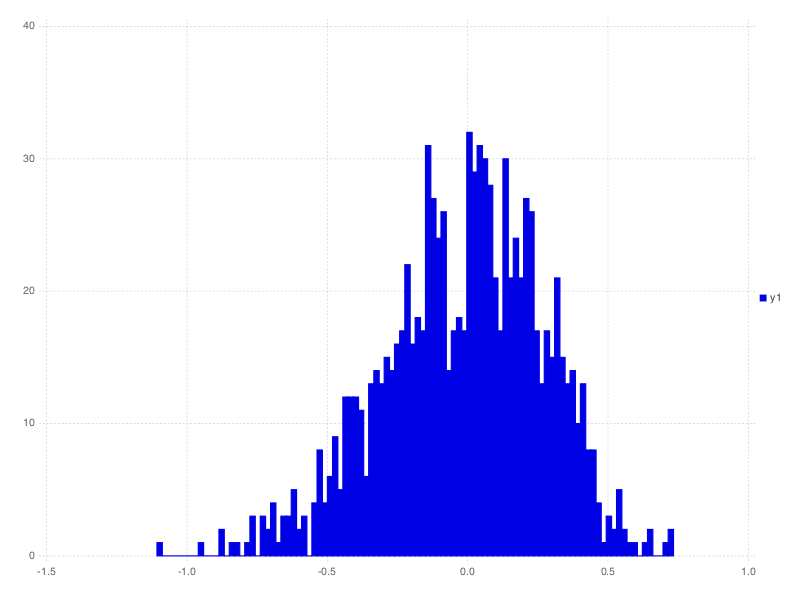

In [102]:
histogram((mean(mm)-mean(vs,1)')/mean(mm))

In [12]:
import DWave.d2a
a=readdlm("/Users/joshuajob/Downloads/QA_TTS_Grover.dat")
d2a(t,x)=(const T = copy(t);T[convert(T,y)::T for y in x])
df = DataFrame(n=d2a(Int64,a[2:end,1]),tf=d2a(Int64,a[2:end,2]),pGS=d2a(Float64,a[2:end,3]),
    TTSlog99=d2a(Float64,a[2:end,4]),TTSmean=d2a(Float64,a[2:end,5]))

,n,tf,pGS,TTSlog99,TTSmean
1,4,25,0.7850768,74.88205,31.84402
2,5,27,0.5593236,151.7364,48.27259
3,6,28,0.3371866,313.5345,83.04008
4,7,36,0.2254565,648.9164,159.676
5,8,39,0.1243831,1352.151,313.5474
6,9,40,0.06285425,2837.598,636.3929
7,10,46,0.03493536,5957.161,1316.717
8,11,50,0.01821948,12522.56,2744.316
9,12,53,0.009228228,26326.41,5743.248
10,13,57,0.004738028,55270.32,12030.32


In [ ]:
run_grover_test(df::DataFrame,Rs::Vector{Int64},Ns::Vector{Int64}) = map(x->run_grover_test(df,x...),prodzip(Rs,Ns))
run_grover_test(df::DataFrame,R::Int64,N::Int64) = test_gauge_average(Binomial(,R,N,n2=10^4)

In [5]:
function dirichlet_process(α,G0)
    ws=Float64[]
    ps=Float64[]
    sps = 1.
    c = Beta(1,α)
    left=1
    while sps>1e-15
        push!(ps,rand(G0))
        push!(ws,rand(c)*sps)
        sps-=ws[end]
    end
    return ws,ps./sum(ps)
end

dirichlet_process (generic function with 1 method)

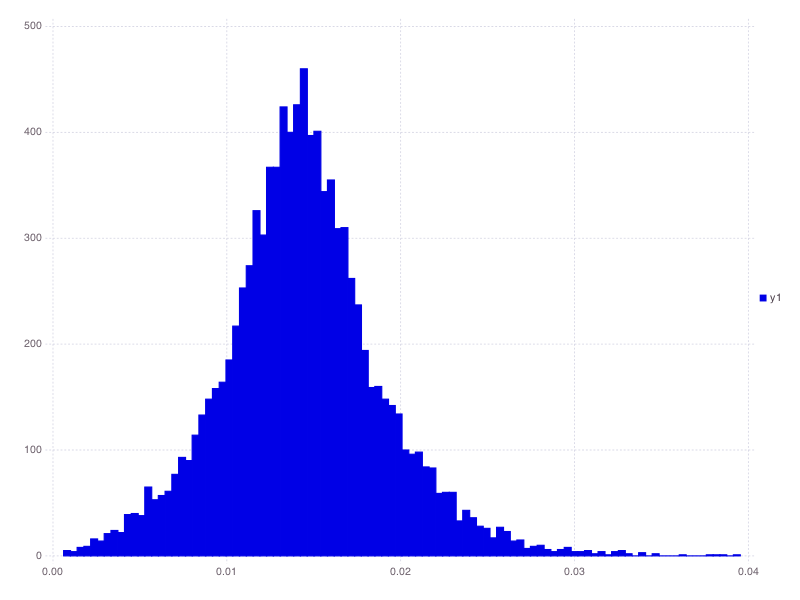

0.313061 seconds (927.85 k allocations: 70.304 MB, 3.75% gc time)


In [15]:
@time histogram([dot(dirichlet_process(2,MixtureModel([Beta(1/2,1/2),DeltaDistribution(0.5,1)]))...)::Float64 for i=1:10^4])


In [2]:
type PointWeightDistribution{T<:Number,Y<:Number}<:Distribution{Univariate,Discrete}
    weights::Vector{Y}
    points::Vector{T}
end

In [3]:
mean(x::PointWeightDistribution)=dot(x.points,x.weights)
quantile(x::PointWeightDistribution,q)=quantile(x.points,WeightVec(x.weights),q)
import Base.Random.rand
import Distributions.cdf,StatsBase.sample
cdf(x::PointWeightDistribution,y::Float64)=sum(x.weights[x.points.<y])

rand(s::PointWeightDistribution)=s.points[rand(Categorical(s.weights))]
rand(s::PointWeightDistribution,N::Int64)=s.points[rand(Categorical(s.weights),N)]

rand (generic function with 126 methods)

In [4]:
type DirichletProcess{T<:Distribution,X<:Number}<:Distribution{Multivariate,Discrete}
    α::X
    G::T
end

In [5]:
function _sample(s::DirichletProcess;cutoff=1e-15)
    α=s.α ; G0=s.G
    ws=Float64[] ; ps=Float64[]
    sps = 1. ; left=1
    c = Beta(1,α)
    while sps>cutoff
        push!(ps,rand(G0))
        push!(ws,rand(c)*sps)
        sps-=ws[end]
    end
    return ws./sum(ws),ps
end
sample(s::DirichletProcess;cutoff=1e-15)=PointWeightDistribution(_sample(s,cutoff=cutoff)...)
sample(s::DirichletProcess,N::Int64;cutoff=1e-15)=[sample(s,cutoff=cutoff)::PointWeightDistribution for i=1:N];
rand(s::DirichletProcess;cutoff=1e-15)=dot(_sample(s,cutoff=cutoff)...)
rand(s::DirichletProcess,N::Int64;cutoff=1e-15)=[dot(_sample(s,cutoff=cutoff)...)::Float64 for i=1:N];
function conjugate_posterior(s::DirichletProcess,theta::Vector{Float64})
    if typeof(s.G)<:MixtureModel
        return DirichletProcess(s.α+length(theta),
            MixtureModel([s.G.components;[DeltaDistribution(t,1)::DeltaDistribution for t in theta]],
        [s.α/(s.α+length(theta)).*s.G.prior.p,1./(s.α+length(theta))]))
    else
        return DirichletProcess(s.α+length(theta),
            MixtureModel([s.G;[DeltaDistribution(t,1)::DeltaDistribution for t in theta]],
                [s.α/(s.α+length(theta));ones(length(theta))./(s.α+length(theta))]))
    end
end
conjugate_posterior(s::DirichletProcess,theta::Float64) = conjugate_posterior(s,collect(theta))

conjugate_posterior (generic function with 2 methods)

  0.527716 seconds (663.52 k allocations: 30.570 MB, 1.22% gc time)
 31.112780 seconds (119.16 k allocations: 2.215 GB, 0.62% gc time)
[Plots.jl] Initializing backend: gadfly
  

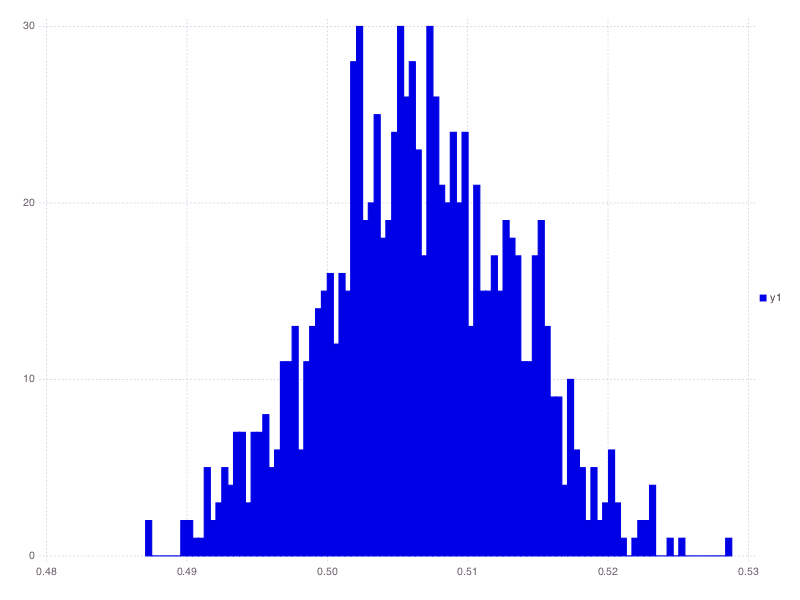

In [7]:
@time d=conjugate_posterior(DirichletProcess(1,Beta(1/2,1/2)),rand(Normal(0.5,0.2),1000))
@time v=rand(d,10^3)
@time histogram(v)

In [8]:
Normal(Base.mean(v),std(v))

8.251220 seconds (10.28 M allocations: 444.142 MB, 1.55% gc time)


Distributions.Normal(μ=0.506457219066955, σ=0.006760622783091435)

In [34]:
f=sample(d)
out=zeros(10^3+1,10^3)
for i=1:10^3
    out[:,i]=cdf(sample(d),0:1e-3:1)
end

In [60]:
df=DataFrame();
df[:q]=repmat(collect(0:1e-3:1),1000)
df[:p]=reshape(out,length(out))
df[:t]=repeach(1:1000,1001);

In [221]:
function _sample(s::DirichletProcess;cutoff=1e-15)
    α=s.α ; G0=s.G
    ws=Float64[] ; ps=Float64[]
    sps = 1. ;
    c = Beta(1,α)
    while sps>cutoff
        push!(ps,rand(G0))
        push!(ws,rand(c)*sps)
        sps-=ws[end]
    end
    return ws./sum(ws),ps
end

function conjugate_posterior(α::Number,G::Distribution,theta::Vector{Float64})
    if typeof(G)<:MixtureModel
        return DirichletProcess(α+length(theta),
            MixtureModel([G.components;[DeltaDistribution(t,1)::DeltaDistribution for t in theta]],
        [α/(α+length(theta)).*G.prior.p,1./(α+length(theta))]))
    else
        return DirichletProcess(α+length(theta),
            MixtureModel([G;[DeltaDistribution(t,1)::DeltaDistribution for t in theta]],
                [α/(α+length(theta));ones(length(theta))./(α+length(theta))]))
    end
end

function dpmmbinpostsample{T<:Real}(α::T,G0::Distribution,numSuccesses,numRuns,N::Int64;cutoff=1e-15)
    betas=Distribution[]
    for i=1:length(numSuccesses)
        if numSuccesses[i]==0
            push!(betas,DeltaDistribution(0,numRuns[i]))
        elseif numSuccesses[i]==numRuns[i]
            push!(betas,DeltaDistribution(1,numRuns[i]))
        else
            push!(betas,Beta(numSuccesses[i],numRuns[i]-numSuccesses[i]))
        end
    end
    return [sample(conjugate_posterior(α,G0,convert(Vector{Float64},map(rand,betas))))::PointWeightDistribution for i=1:N]
end

dpmmbinpostsample (generic function with 1 method)

In [226]:
@time v=map(mean,dpmmbinpostsample(1.,Uniform(0,1),rand(Binomial(100,1e-4),10^3),100*ones(Int64,10^3),100));

  4.053568 seconds (318.75 k allocations: 239.252 MB, 4.00% gc time)


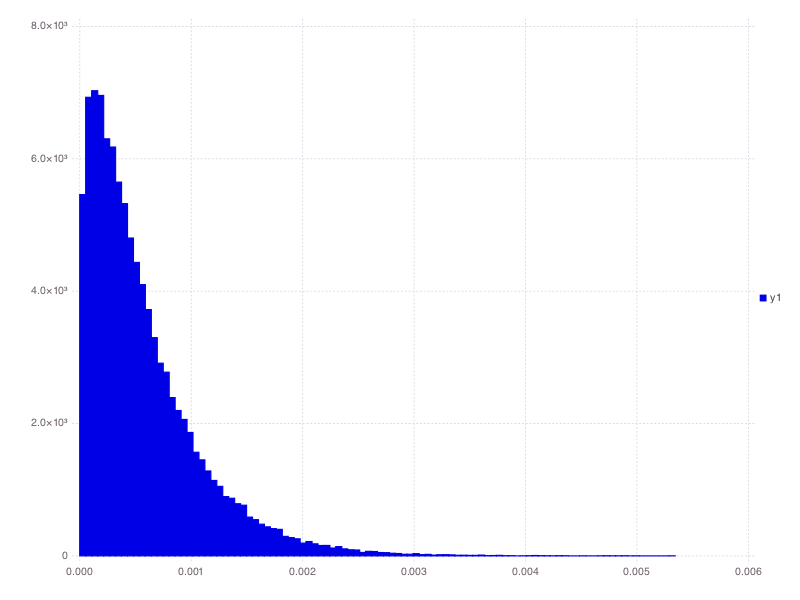

In [235]:
histogram(rand(fit(Beta,v),10^5))

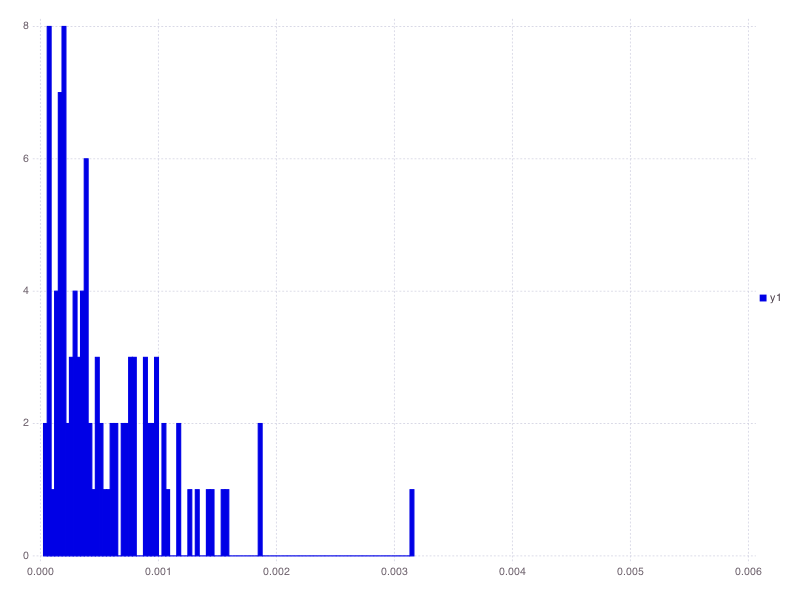

In [237]:
histogram(v,xticks=0:1e-3:6e-3)

In [67]:
using Plots

[Plots.jl] Default backend: immerse


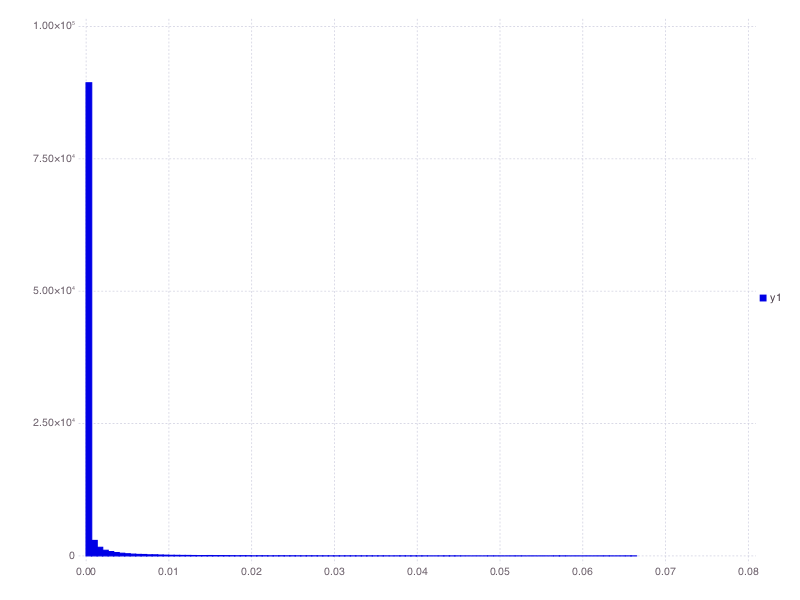

In [72]:
histogram(rand(Beta(1/20,100),10^5),xticks=0:0.01:0.08)

In [252]:
1/mean(mm)

671.5867158671587

In [3]:
a=load("/Volumes/Data/Josh/Ising/tts99_fullZhihui.jld");

In [79]:
df=a["df_beta"];
df[:TTS]=[mean(x)::Float64 for x in df[:x1]];
df[:p] = 1.-exp(log(0.01)./df[:TTS]);
df[:t] = 1./(100df[:p]);
df=df[:,[1:3;5;6;7]];

In [69]:
function est_time_to_run(t)
    tp = sort(t)
    t1=Float64[]
    t2=Float64[]
    N = length(t)
    for q in 0.01:0.01:0.99
        push!(t1,sum(t[1:round(Integer,N*q)]))
        push!(t2,N*quantile(t,q))
    end
    return DataFrame(q=Float64[0.01:0.01:0.99;],optional_stopping=t1,fixed_sample_size=t2)
end

est_time_to_run (generic function with 1 method)

In [51]:
using Gadfly,Interact

In [81]:
df2=melt(by(df,:Nq,x->est_time_to_run(x[:t])),[:Nq,:q]);
rename!(df2,:variable,:stopping_rule);rename!(df2,:value,:num_gauges);

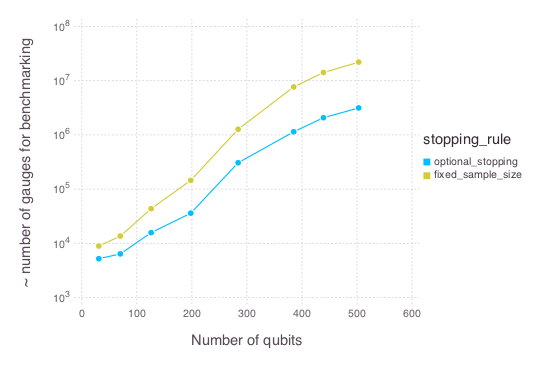

In [82]:
q = 0.95
plot(restrict(df2,Dict(:q=>q)),x=:Nq,y=:num_gauges,color=:stopping_rule,
Geom.point,Geom.line,Geom.errorbar,Scale.y_log10,Guide.ylabel("~ number of gauges for benchmarking"),
Guide.xlabel("Number of qubits"))

In [89]:
A=readtable("results.tsv")
A[:dist]=repeach([Beta(1,99);Beta(1,999);Beta(1,9999);DeltaDistribution(1/100,1);DeltaDistribution(1/1000,1);
    DeltaDistribution(1/10000,1);Uniform();Beta(1/2,1000);
    MixtureModel([Beta(10,1000),Beta(1,1),Beta(1/2,100)],[0.2,0.01,0.79]);
    MixtureModel([Beta(33,7800),Beta(12,2^14)],[0.3,0.7]);MixtureModel([Beta(5,10^4),Beta(2,2)],[0.998,0.002]);
    MixtureModel([Beta(3,1000),DeltaDistribution(0.9,1)],[0.95,0.05])],12);
A[:p]=1./A[:mean];
A

,R,threshold,wallclock_time,p67ci,p95ci,p99ci,p1σ,p2σ,p3σ,mean,avg_percent_error,dist,p
1,50,0.05,60.02399999998618,91,100,100,100,100,100,458.2105765533884,-0.002302439786075361,"Distributions.Beta(α=1.0, β=99.0)",0.0021824027012250446
2,50,0.1,17.30399999999213,84,100,100,100,100,100,458.2105765533884,-0.012123283748748381,"Distributions.Beta(α=1.0, β=99.0)",0.0021824027012250446
3,50,0.2,5.279999999994946,86,100,100,100,100,100,458.2105765533884,-0.03668828336994845,"Distributions.Beta(α=1.0, β=99.0)",0.0021824027012250446
4,100,0.05,50.423999999984765,81,99,100,100,100,100,458.2105765533884,-0.001035921744211521,"Distributions.Beta(α=1.0, β=99.0)",0.0021824027012250446
5,100,0.1,14.453999999985202,83,99,100,100,100,100,458.2105765533884,-0.005009484653218488,"Distributions.Beta(α=1.0, β=99.0)",0.0021824027012250446
6,100,0.2,4.68170999999355,92,100,100,100,100,100,458.2105765533884,-0.011212165241562655,"Distributions.Beta(α=1.0, β=99.0)",0.0021824027012250446
7,150,0.05,49.89600000002066,81,98,100,100,100,100,458.2105765533884,-0.0009886364891040778,"Distributions.Beta(α=1.0, β=99.0)",0.0021824027012250446
8,150,0.1,14.700000000016603,83,99,100,100,100,100,458.2105765533884,-0.011709845050396517,"Distributions.Beta(α=1.0, β=99.0)",0.0021824027012250446
9,150,0.2,4.8165600000057855,84,99,100,100,100,100,458.2105765533884,-0.0450810097890908,"Distributions.Beta(α=1.0, β=99.0)",0.0021824027012250446
10,200,0.05,52.428000000001965,73,98,100,100,100,100,458.2105765533884,-0.0004231303703026157,"Distributions.Beta(α=1.0, β=99.0)",0.0021824027012250446


In [132]:
set_default_plot_size(12inch,4inch)
for R=[50,100,150,200]
    draw(PDF("mean_v_wallclocktime_R_$R"*".pdf",6inch,4inch),
    plot(A[A[:R].==R,:],x=:mean,y=:wallclock_time,Geom.point,Geom.line,color=:threshold,Scale.y_log10,Scale.x_log10,
    Guide.ylabel("Wall clock time"),Guide.xlabel("inverse mean"))
    )
end

In [133]:
for threshold=[0.05,0.1,0.2]
    draw(PDF("mean_v_wallclocktime_threshold_$threshold"*".pdf",6inch,4inch),
    plot(A[A[:threshold].==threshold,:],x=:mean,y=:wallclock_time,Geom.point,Geom.line,color=:R,Scale.y_log10,Scale.x_log10,
    Guide.ylabel("Wall clock time"),Guide.xlabel("inverse mean"))
    )
end

In [140]:
#for threshold=[0.05,0.1,0.2]
draw(PDF("errors"*".pdf",6inch,4inch),
plot(A,ygroup=:R,xgroup=:threshold,x=:avg_percent_error,Geom.subplot_grid(Geom.histogram),
Guide.ylabel("Percent error of the mean"),Guide.xlabel("percent error by threshold"))
    )
#end

In [144]:
draw(PDF("p67ci"*".pdf",6inch,4inch),
plot(A,ygroup=:R,xgroup=:threshold,x=:p67ci,Geom.subplot_grid(Geom.histogram),
Guide.xlabel("67 percent credible interval performance by threshold"))
    )
draw(PDF("p95ci"*".pdf",6inch,4inch),
plot(A,ygroup=:R,xgroup=:threshold,x=:p95ci,Geom.subplot_grid(Geom.histogram),
Guide.xlabel("95 percent credible interval performance by threshold"))
    )
draw(PDF("p99ci"*".pdf",6inch,4inch),
plot(A,ygroup=:R,xgroup=:threshold,x=:p99ci,Geom.subplot_grid(Geom.histogram),
Guide.xlabel("99 percent credible interval performance by threshold"))
    )

In [127]:
by(A,[:threshold,:dist],x->x[indmin(x[:avg_percent_error]),[1;3:11;13]])

,threshold,dist,R,wallclock_time,p67ci,p95ci,p99ci,p1σ,p2σ,p3σ,mean,avg_percent_error,p
1,0.05,"Distributions.Beta(α=1.0, β=99.0)",50,60.02399999998618,91,100,100,100,100,100,458.2105765533884,-0.002302439786075361,0.0021824027012250446
2,0.05,"Distributions.Beta(α=1.0, β=999.0)",100,337.85399999996156,86,100,100,100,100,100,4602.867216938907,-0.007454600592737393,0.00021725588700884584
3,0.05,"Distributions.Beta(α=1.0, β=9999.0)",150,2542.3859999990946,93,100,100,100,100,100,46049.39923641465,-0.008540356663559123,2.1715809903752805e-5
4,0.05,"DWave.DeltaDistribution(δ=0.01, N=1)",150,34.31399999999683,89,100,100,100,100,100,458.2105765533884,-0.007280812252669966,0.0021824027012250446
5,0.05,"DWave.DeltaDistribution(δ=0.001, N=1)",100,324.38999999994957,90,100,100,100,100,100,4602.867216938907,-0.0070366845179477,0.00021725588700884584
6,0.05,"DWave.DeltaDistribution(δ=0.0001, N=1)",50,3980.1359999988426,92,100,100,100,100,100,46049.39923641465,-0.0037770995154065012,2.1715809903752805e-5
7,0.05,"Distributions.Uniform(a=0.0, b=1.0)",200,17.951999999998428,64,96,100,100,100,100,6.643856189774724,-0.004317070615191598,0.1505149978319906
8,0.05,"Distributions.Beta(α=0.5, β=1000.0)",100,647.2290000000006,86,100,100,100,100,100,9212.64276523514,-0.006411870395687247,0.00010854648611510298
9,0.05,"MixtureModel{Distributions.Beta}(K = 3) components[1] (prior = 0.2000): Distributions.Beta(α=10.0, β=1000.0) components[2] (prior = 0.0100): Distributions.Beta(α=1.0, β=1.0) components[3] (prior = 0.7900): Distributions.Beta(α=0.5, β=100.0)",150,450.61800000012386,65,93,100,100,100,100,419.7774954262474,-0.011648535964808415,0.0023822144133395892
10,0.05,"MixtureModel{Distributions.Beta}(K = 2) components[1] (prior = 0.3000): Distributions.Beta(α=33.0, β=7800.0) components[2] (prior = 0.7000): Distributions.Beta(α=12.0, β=16384.0)",150,174.88800000001035,93,100,100,100,100,100,2590.400667399916,-0.00478724689403176,0.00038604066644398223
